In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Flatten, Reshape, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import numpy as np
import os
import pandas as pd
import pywt

In [2]:
epoch_num = 5
sequence_length = 8  # Number of time steps to consider

# Define file and directory names
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
# parent_dir = 'forexPredictor'
# repo = 'Repos_git'
# repo_dir = 'Make_Money_with_Tensorflow_2.0'
# Get the absolute base directory dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Move up one level

# Construct the full file path in an OS-independent way
# data_path = os.path.join(base_dir, repo, repo_dir, parent_dir, data_dir, file_name)
data_path = os.path.join(base_dir, data_dir, file_name)

# Check if the file exists before using it
if os.path.exists(data_path):
    print(f"✅ File found: {data_path}")
else:
    print(f"❌ Error: File not found at {data_path}")


ucols=['Open', 'High', 'Low', 'Close']
data_main = pd.read_csv(data_path, usecols=ucols)
data_main.reset_index(drop=True, inplace=True)
data_main.head()


✅ File found: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\0_61938.csv


,Open,High,Low,Close
0,1.20997,1.21089,1.20966,1.20999
1,1.20481,1.20569,1.20479,1.20538
2,1.20537,1.20574,1.20341,1.20553
3,1.20556,1.20689,1.20442,1.20469
4,1.20468,1.20599,1.20380,1.20573


In [3]:
df = data_main.iloc[:30000]
# Convert DataFrame to NumPy array
# data = df.values

<Axes: >

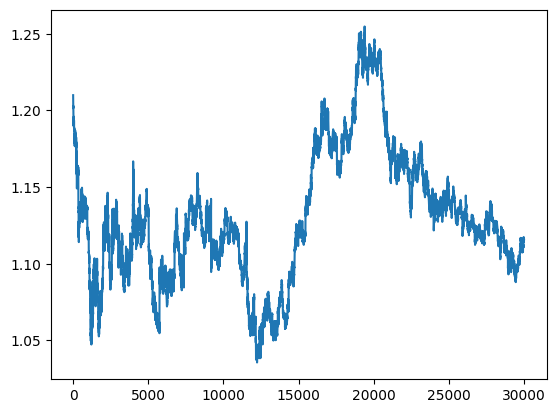

In [4]:
df['Close'].plot()

In [8]:
# Normalize Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

def apply_dwt(data):
    coeffs = [pywt.dwt(sample, 'haar') for sample in data]
    cA, cD = zip(*coeffs)
    return np.array(cA)  # Using only approximation coefficients

# Apply DWT
transformed_data = apply_dwt(df_scaled)

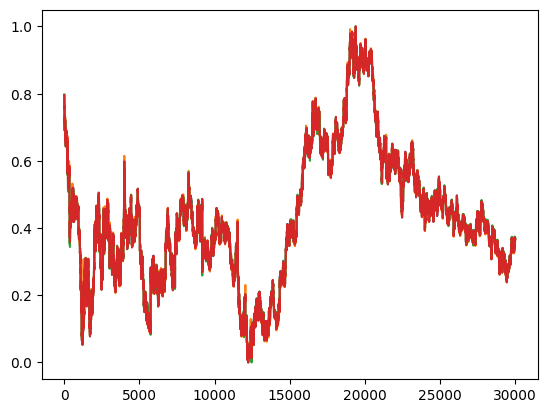

In [9]:
plt.plot(df_scaled)

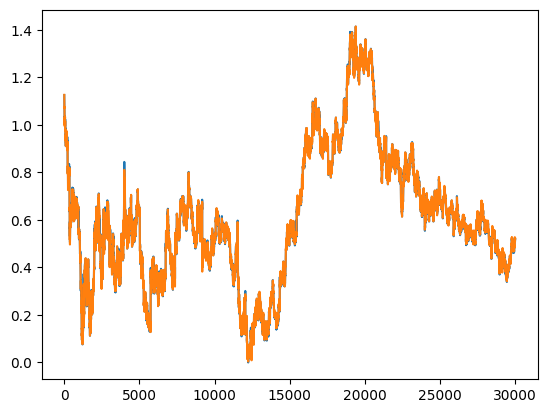

In [10]:
plt.plot(transformed_data)

In [13]:
# Convert Data into Time Series Sequences
def create_sequences(data, time_steps=30):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])  # Past 30 days as input
        labels.append(1 if data[i + time_steps][-1] > data[i + time_steps - 1][-1] else 0)  # Binary trend label
    return np.array(sequences), np.array(labels)

In [14]:
time_steps = 30
X, y = create_sequences(transformed_data, time_steps)


In [16]:
X.shape

(29970, 30, 2)

In [20]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [24]:
def create_autoencoder_decoder():
    # Define Autoencoder Model
    latent_dim = 16
    input_layer = Input(shape=(30, 2))  # Adjust input shape to match X.shape

    # Encoder
    encoded = LSTM(64, activation="relu", return_sequences=True)(input_layer)
    encoded = LSTM(latent_dim, activation="relu", return_sequences=False)(encoded)

    # Decoder
    decoded = RepeatVector(30)(encoded)
    decoded = LSTM(64, activation="relu", return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(2))(decoded)  # Output should also match input (2 features)

    # Autoencoder Model
    autoencoder = Model(input_layer, decoded)
    
    # Extract the encoder part from the autoencoder model
    encoder = Model(autoencoder.input, autoencoder.layers[2].output)
    autoencoder.compile(optimizer="adam", loss="mse")

    return autoencoder, encoder

# Create and Train Autoencoder
auto_encoder, encoder = create_autoencoder_decoder()
auto_encoder.fit(X_train, X_train, epochs=5, batch_size=32, verbose=1)


Epoch 1/5
750/750 [==============================] - 23s 26ms/step - loss: 0.0109
Epoch 2/5
750/750 [==============================] - 21s 29ms/step - loss: 3.3882e-04
Epoch 3/5
750/750 [==============================] - 21s 28ms/step - loss: 2.9407e-04
Epoch 4/5
750/750 [==============================] - 22s 30ms/step - loss: 2.2044e-04
Epoch 5/5
750/750 [==============================] - 18s 24ms/step - loss: 1.9095e-04


In [25]:
# Transform Data into Latent Features
features = encoder.predict(X_train)

print("Extracted Features Shape:", features.shape)  # Expected: (num_samples, latent_dim)

750/750 [==============================] - 9s 11ms/step
Extracted Features Shape: (23976, 16)


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict reconstructed sequences
X_train_pred = auto_encoder.predict(X_train)
X_test_pred = auto_encoder.predict(X_test)

# Compute MSE, MAE, and R²
mse_train = mean_squared_error(X_train.flatten(), X_train_pred.flatten())
mae_train = mean_absolute_error(X_train.flatten(), X_train_pred.flatten())
r2_train = r2_score(X_train.flatten(), X_train_pred.flatten())

mse_test = mean_squared_error(X_test.flatten(), X_test_pred.flatten())
mae_test = mean_absolute_error(X_test.flatten(), X_test_pred.flatten())
r2_test = r2_score(X_test.flatten(), X_test_pred.flatten())

# Print Performance Metrics
print(f"Train MSE: {mse_train:.4f}, Train MAE: {mae_train:.4f}, Train R²: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, Test MAE: {mae_test:.4f}, Test R²: {r2_test:.4f}")


188/188 [==============================] - 2s 12ms/step
Train MSE: 0.0002, Train MAE: 0.0094, Train R²: 0.9979
Test MSE: 0.0002, Test MAE: 0.0093, Test R²: 0.9979


In [134]:

# Define LSTM Autoencoder
def create_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input_layer)
    x = LSTM(32, return_sequences=False)(x)
    encoded = Dense(16, activation='relu')(x)
    
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(input_shape[0], activation='sigmoid')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder


transformed_data_reshaped = transformed_data.reshape((transformed_data.shape[0], transformed_data.shape[1], 1))
# Train Autoencoder
autoencoder, encoder = create_autoencoder(transformed_data.shape[1:])
autoencoder.fit(transformed_data, transformed_data, epochs=5, batch_size=32, verbose=1)

# Extract Features
features = encoder.predict(transformed_data)


In [27]:
# Apply TimeSeriesKMeans with Dynamic Time Warping (DTW)
n_clusters = 3  # Buy (1), Sell (-1), Hold (0)
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
clusters = kmeans.fit_predict(features)

print("Cluster Labels:", np.unique(clusters, return_counts=True))  # Check cluster distribution

# Map Clusters to Trading Decisions
cluster_labels = {0: -1, 1: 0, 2: 1}  # Assign Sell (-1), Hold (0), Buy (1)
y_clustered = np.array([cluster_labels[c] for c in clusters])

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, y_clustered)

print("Balanced Class Distribution:", np.unique(y_resampled, return_counts=True))




Cluster Labels: (array([0, 1, 2], dtype=int64), array([ 6664,  5174, 12138], dtype=int64))
Balanced Class Distribution: (array([-1,  0,  1]), array([12138, 12138, 12138], dtype=int64))


NameError: name 'OneHotEncoder' is not defined

In [31]:
from sklearn.ensemble import RandomForestClassifier

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y_resampled.reshape(-1, 1))

print("One-Hot Encoded Labels Shape:", y_encoded.shape)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_encoded, test_size=0.2, random_state=42)

# Train RandomForest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


One-Hot Encoded Labels Shape: (36414, 3)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2326
           1       1.00      1.00      1.00      2518
           2       1.00      1.00      1.00      2439

    accuracy                           1.00      7283
   macro avg       1.00      1.00      1.00      7283
weighted avg       1.00      1.00      1.00      7283



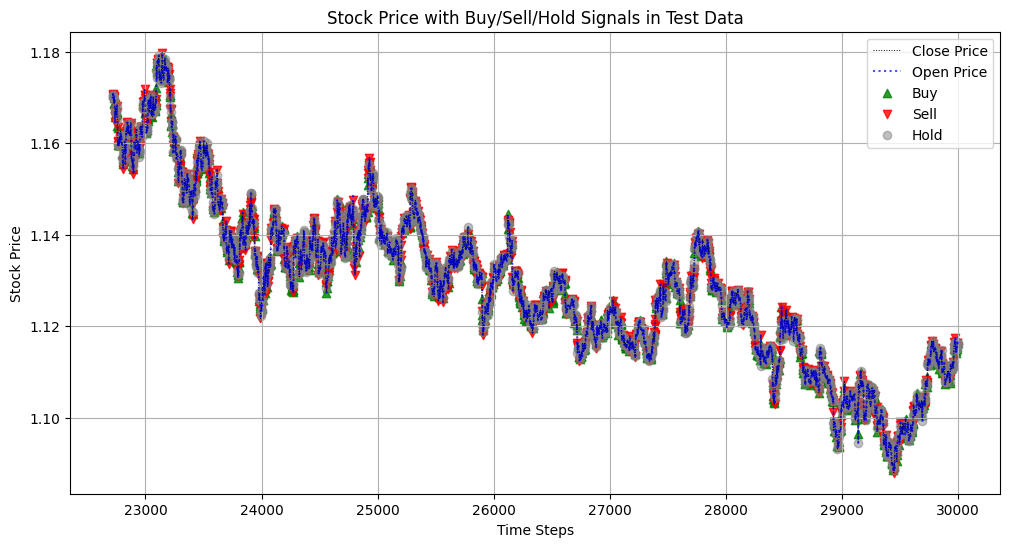

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure indices align correctly
df_test = df.iloc[-len(X_test):].copy()  # Copy test data portion

# Convert predicted classes to Pandas Series
y_pred_classes = y_pred.argmax(axis=1)  # Assuming y_pred is one-hot encoded
y_pred_series = pd.Series(y_pred_classes, index=df_test.index)

# Map class labels back to Buy, Sell, Hold
label_mapping = {2: 1, 1: -1, 0: 0}  # Assuming 2=Buy, 1=Sell, 0=Hold
y_pred_series = y_pred_series.map(label_mapping)

# Plot OHLC Data
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test["Close"], label='Close Price', linestyle='dotted', linewidth=0.7, color="black")
plt.plot(df_test.index, df_test["Open"], label='Open Price', linestyle='dotted', alpha=0.7, color="blue")

# Find Buy, Sell, Hold signals
buy_signals = df_test.index[y_pred_series == 1]
sell_signals = df_test.index[y_pred_series == -1]
hold_signals = df_test.index[y_pred_series == 0]

# Plot Signals on Close Price
plt.scatter(buy_signals, df_test.loc[buy_signals, "Close"], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, df_test.loc[sell_signals, "Close"], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, df_test.loc[hold_signals, "Close"], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Signals in Test Data")
plt.grid(True)
plt.show()


In [33]:
y_pred_series

22717    0
22718   -1
22719    0
22720    1
22721   -1
        ..
29995    1
29996    0
29997    0
29998    0
29999    0
Length: 7283, dtype: int64

In [135]:


# Clustering with TimeSeriesKMeans
num_clusters = 3  # Buy (2), Sell (1), Hold (0)
tskmeans = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", random_state=42)
clusters = tskmeans.fit_predict(features)
clusters_one_hot = tf.keras.utils.to_categorical(clusters, num_clusters)

# Split Data for Training
X_train, X_test, y_train, y_test = train_test_split(features, clusters_one_hot, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42, sampling_strategy='not majority')
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define Classifier
input_shape = features.shape[1:]  # Extract feature dimension
classifier_input = Input(shape=input_shape)
classifier_output = Dense(num_clusters, activation="softmax")(classifier_input)

classifier = Model(classifier_input, classifier_output)

Epoch 1/5
938/938 [==============================] - 5s 3ms/step - loss: 0.0126
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0047
Epoch 3/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 4/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0046
Epoch 5/5
938/938 [==============================] - 2s 1ms/step


In [136]:
# Convert one-hot encoded labels to integer class labels
y_train_classes = np.argmax(y_train, axis=1)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Convert to dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# ✅ Recompile model after setting class weights
classifier.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train Classifier with Class Weights
classifier.fit(X_train, y_train, 
               validation_data=(X_test, y_test), 
               epochs=5, 
               batch_size=32, 
               class_weight=class_weight_dict)

# Save the model
classifier.save('model.h5')

# Evaluate Model
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/5
1662/1662 [==============================] - 3s 1ms/step - loss: 0.3077 - accuracy: 0.9442 - val_loss: 0.1452 - val_accuracy: 0.9832
Epoch 2/5
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0903 - accuracy: 0.9935 - val_loss: 0.0693 - val_accuracy: 0.9885
Epoch 3/5
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0550 - accuracy: 0.9944 - val_loss: 0.0460 - val_accuracy: 0.9900
Epoch 4/5
1662/1662 [==============================] - 2s 1ms/step - loss: 0.0407 - accuracy: 0.9951 - val_loss: 0.0350 - val_accuracy: 0.9907
Epoch 5/5
 99/188 [==============>...............] - ETA: 0s - loss: 0.0271 - accuracy: 0.9924

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - 0s 1ms/step - loss: 0.0280 - accuracy: 0.9915
Test Accuracy: 99.15%


188/188 [==============================] - 0s 935us/step
Confusion Matrix:
[[1121    5    0]
 [   0  383    0]
 [  46    0 4445]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1126
           1       0.99      1.00      0.99       383
           2       1.00      0.99      0.99      4491

    accuracy                           0.99      6000
   macro avg       0.98      1.00      0.99      6000
weighted avg       0.99      0.99      0.99      6000



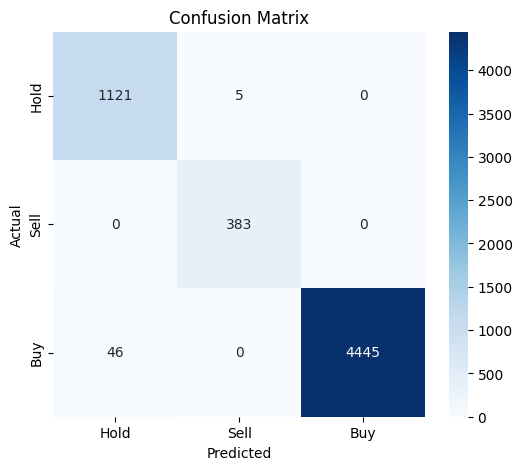

In [137]:
# Confusion Matrix & Classification Report
y_pred = classifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=['Hold', 'Sell', 'Buy'], yticklabels=['Hold', 'Sell', 'Buy'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

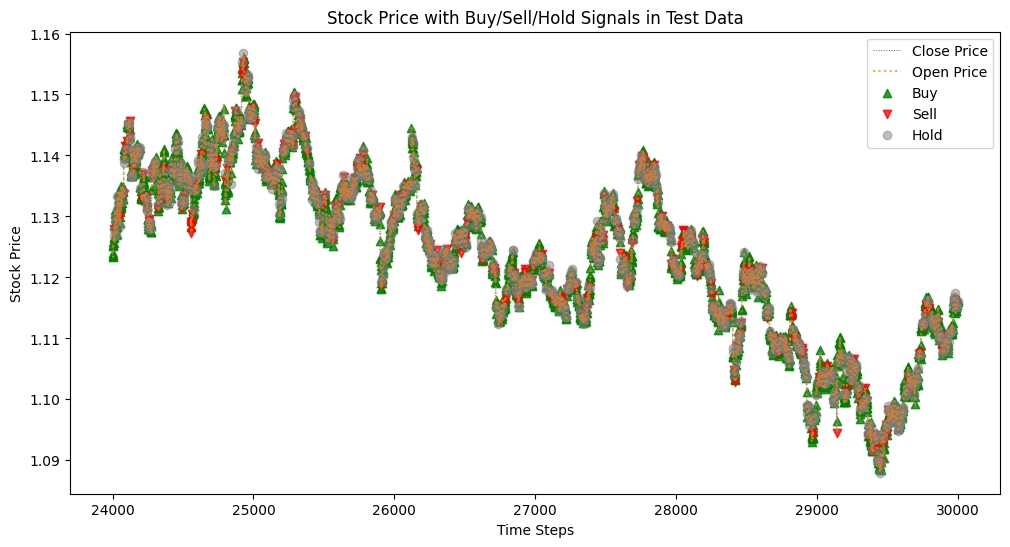

In [138]:
# Ensure indices align correctly
df_test = df.iloc[-len(X_test):].copy()  # Copy test data portion

# Convert y_pred_classes to Pandas Series with the correct index
y_pred_series = pd.Series(y_pred_classes, index=df_test.index)

# Plot OHLC Data
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test["Close"], label='Close Price', linestyle='dotted', linewidth=0.7)
plt.plot(df_test.index, df_test["Open"], label='Open Price', linestyle='dotted', alpha=0.7)
# plt.plot(df_test.index, df_test["High"], label='High Price', linestyle='dotted', alpha=0.7)
# plt.plot(df_test.index, df_test["Low"], label='Low Price', linestyle='dotted', alpha=0.7)

# Find Buy, Sell, Hold signals
buy_signals = df_test.index[y_pred_series == 2]
sell_signals = df_test.index[y_pred_series == 1]
hold_signals = df_test.index[y_pred_series == 0]

# Plot Signals on Close Price
plt.scatter(buy_signals, df_test.loc[buy_signals, "Close"], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, df_test.loc[sell_signals, "Close"], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, df_test.loc[hold_signals, "Close"], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Signals in Test Data")
plt.show()


In [34]:
# documentation: https://www.mql5.com/en/docs/integration/python_metatrader5

import MetaTrader5 as mt  # pip install MetaTrader5
import pandas as pd  # pip install pandas
from datetime import datetime, timedelta
import os

# start the platform with initialize()
mt.initialize()

# login to Trade Account with login()
# make sure that trade server is enabled in MT5 client terminal

login = 165905041
password = 'iIeElL0176_'
server = 'XMGlobal-MT5 2'

mt.login(login, password, server)



# Define symbol and timeframe
symbol = "EURUSD"
timeframe = mt.TIMEFRAME_H1

# Get data for the last 48 hours
end_time = datetime.now()
start_time = end_time - timedelta(hours=1000)

# Retrieve OHLC data
ohlc_data = pd.DataFrame(mt.copy_rates_range(symbol, timeframe, start_time, end_time))

# Convert time column to datetime format
ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')


ohlc_data.rename(columns={'open':'Open', 'high':'High', 
                        'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
columns_to_drop = ['time', 'spread', 'real_volume', 'Volume']
ohlc_data.drop(columns=[col for col in columns_to_drop if col in ohlc_data.columns], inplace=True)



In [140]:
ohlc_data

,Open,High,Low,Close
0,1.04362,1.04651,1.04346,1.04607
1,1.04610,1.04665,1.04562,1.04627
2,1.04622,1.04676,1.04576,1.04654
3,1.04653,1.04663,1.04551,1.04606
4,1.04607,1.04661,1.04569,1.04599
...,...,...,...,...
708,1.07720,1.07735,1.07532,1.07640
709,1.07642,1.07759,1.07547,1.07751
710,1.07749,1.07781,1.07601,1.07698
711,1.07697,1.07808,1.07658,1.07808


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Normalize Data using the same scaler
new_df_scaled = scaler.transform(new_df)  # Ensure same scaling as training

# Apply DWT Transformation
new_transformed_data = apply_dwt(new_df_scaled)
# new_transformed_data = new_transformed_data.reshape((new_transformed_data.shape[0], new_transformed_data.shape[1], 1))

# Ensure data shape matches the encoder input
print("Transformed Data Shape:", new_transformed_data.shape)

# Extract Features using Encoder
new_features = encoder.predict(new_transformed_data)

# Predict Buy/Sell/Hold Signals
new_predictions = classifier.predict(new_features)
new_pred_classes = np.argmax(new_predictions, axis=1)  # Convert probabilities to class labels

# Correct Label Mapping (Ensures consistency)
label_mapping = {2: 1, 1: -1, 0: 0}  # Convert back to Buy=1, Sell=-1, Hold=0
new_pred_series = pd.Series(new_pred_classes, index=new_df.index).map(label_mapping)

# Plot OHLC Data
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df["Close"], label='Close Price', color='blue', linewidth=2)
plt.plot(new_df.index, new_df["Open"], label='Open Price', linestyle='dashed', alpha=0.7)
plt.plot(new_df.index, new_df["High"], label='High Price', linestyle='dotted', alpha=0.7)
plt.plot(new_df.index, new_df["Low"], label='Low Price', linestyle='dotted', alpha=0.7)

# Find Buy, Sell, Hold signals
buy_signals = new_df.index[new_pred_series == 1]
sell_signals = new_df.index[new_pred_series == -1]
hold_signals = new_df.index[new_pred_series == 0]

# Plot Buy/Sell/Hold Markers
plt.scatter(buy_signals, new_df.loc[buy_signals, "Close"], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, new_df.loc[sell_signals, "Close"], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, new_df.loc[hold_signals, "Close"], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Predictions on New Data")
plt.grid(True)
plt.show()

# Save Predictions
new_df["Prediction"] = new_pred_series.map({0: "Hold", -1: "Sell", 1: "Buy"})
new_df.to_csv("predicted_results_new.csv", index=False)

# Print first 10 rows
print(new_df.head(10))


Transformed Data Shape: (680, 2)


AttributeError: 'OneHotEncoder' object has no attribute 'predict'

In [35]:
new_df = ohlc_data

# Normalize Data using the same scaler
new_df_scaled = scaler.transform(new_df)  # Use the previously fitted scaler

# Apply DWT Transformation
new_transformed_data = apply_dwt(new_df_scaled)
new_transformed_data = new_transformed_data.reshape((new_transformed_data.shape[0], new_transformed_data.shape[1], 1))

# Extract Features using the Encoder
new_features = encoder.predict(new_transformed_data)

# Predict Buy/Sell/Hold Signals
new_predictions = classifier.predict(new_features)
new_pred_classes = np.argmax(new_predictions, axis=1)  # Convert probabilities to class labels

# Convert predictions to a Pandas Series with matching index
new_pred_series = pd.Series(new_pred_classes, index=new_df.index)

# Plot OHLC with Predictions
plt.figure(figsize=(12, 6))
plt.plot(new_df.index, new_df["Close"], label='Close Price', color='blue', linewidth=2)
plt.plot(new_df.index, new_df["Open"], label='Open Price', linestyle='dashed', alpha=0.7)
plt.plot(new_df.index, new_df["High"], label='High Price', linestyle='dotted', alpha=0.7)
plt.plot(new_df.index, new_df["Low"], label='Low Price', linestyle='dotted', alpha=0.7)

# Find Buy, Sell, Hold signals
buy_signals = new_df.index[new_pred_series == 2]
sell_signals = new_df.index[new_pred_series == 1]
hold_signals = new_df.index[new_pred_series == 0]

# Plot Signals on Close Price
plt.scatter(buy_signals, new_df.loc[buy_signals, "Close"], marker='^', color='green', label='Buy', alpha=0.8)
plt.scatter(sell_signals, new_df.loc[sell_signals, "Close"], marker='v', color='red', label='Sell', alpha=0.8)
plt.scatter(hold_signals, new_df.loc[hold_signals, "Close"], marker='o', color='gray', label='Hold', alpha=0.5)

plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price with Buy/Sell/Hold Predictions on New Data")
plt.show()

# Save Predictions
new_df["Prediction"] = new_pred_series.map({0: "Hold", 1: "Sell", 2: "Buy"})
new_df.to_csv("predicted_results_new.csv", index=False)

# Print first 10 rows of results
print(new_df.head(10))


AttributeError: 'OneHotEncoder' object has no attribute 'predict'

In [ ]:
new_df.Prediction.values


In [142]:
unique, counts = np.unique(y_test_classes, return_counts=True)
print("Class Distribution in Test Data:", dict(zip(unique, counts)))

Class Distribution in Test Data: {0: 1126, 1: 383, 2: 4491}
